In [1]:
import pandas as pd
import geopandas as gp
import os
import numpy as np
import matplotlib.ticker as mtick

# Joining '18 and '20 Congressional Results to Town / Ward Shapefile

In [2]:
#Load in VEST files
vest_me_18 = gp.read_file("./raw-from-source/me_2018/me_2018.shp")
vest_me_20 = gp.read_file("./raw-from-source/me_2020/me_2020.shp")

<AxesSubplot:>

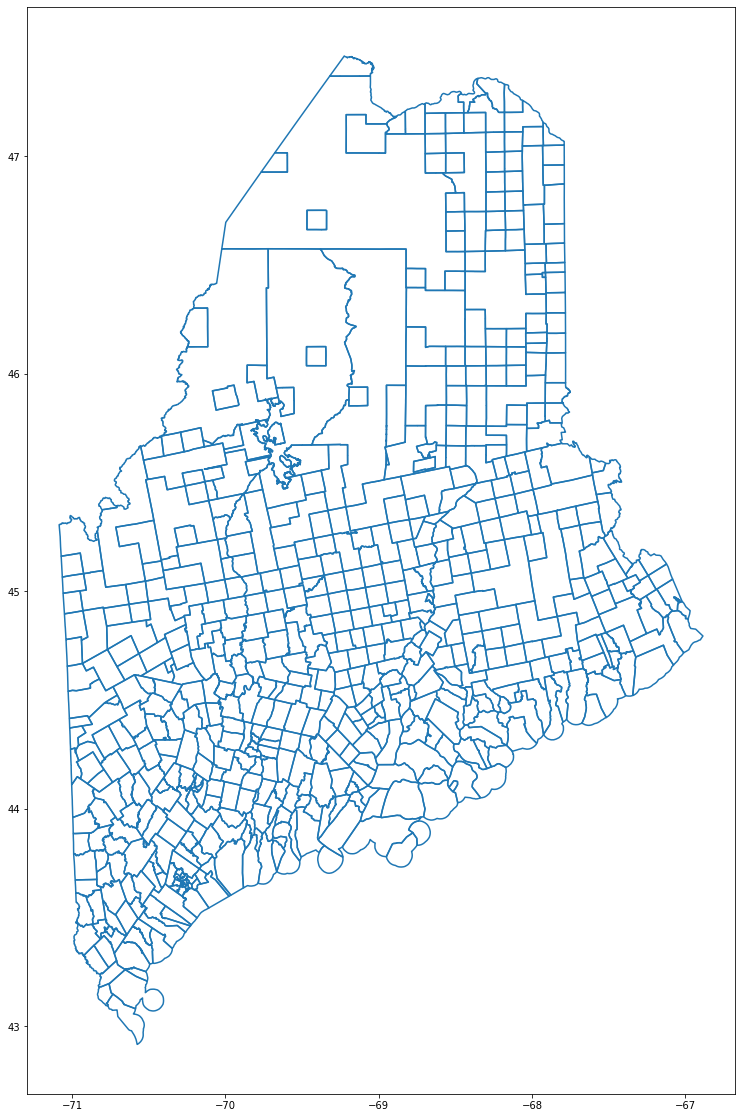

In [3]:
#Take a look
vest_me_20.boundary.plot(figsize = (20,20))

<AxesSubplot:>

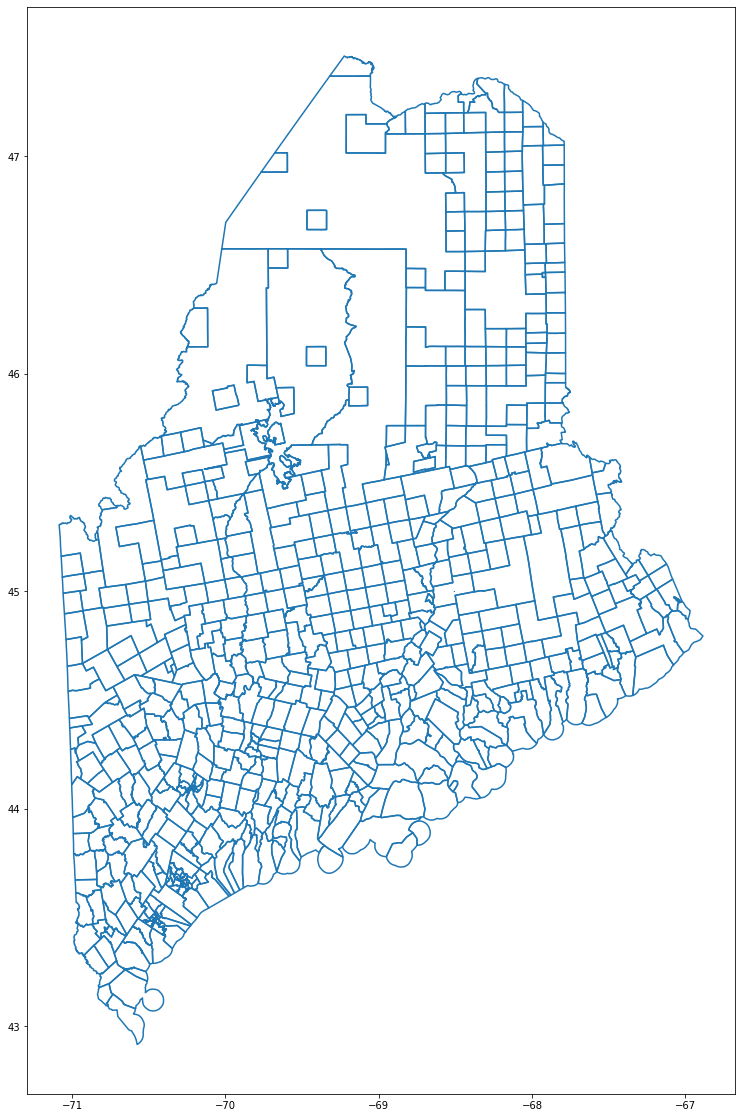

In [4]:
#Take a look
vest_me_18.boundary.plot(figsize = (20,20))

## Cleaning / Processing

In [5]:
#Load in various file I was emailed
#Note: I split these up into their own csvs
results_20 = pd.read_csv("./raw-from-source/us_house_20.csv")
mapping_20 = pd.read_csv("./raw-from-source/precinct_mapping_20.csv")
results_18 = pd.read_csv("./raw-from-source/ushouse_results_18.csv")
mapping_18 = pd.read_csv("./raw-from-source/mapping_18.csv")

#Add a column that I will use as the join column
results_18["me_town_18"] = results_18["vest_town"]
results_20["me_town_20"] = results_20["vest_town"]

#Filter down the VEST data to the needed columns
vest_me_18 = vest_me_18[["STATEFP","COUNTYFP","NAME","geometry"]]
vest_me_20 = vest_me_20[["STATEFP20","COUNTY20","NAME20","geometry"]]

#Create a dictionary to map from precinct to town
dict_18 = dict(zip(mapping_18["vest_precinct"],mapping_18["vest_town"]))
dict_20 = dict(zip(mapping_20["vest_precinct"],mapping_20["vest_town"]))

#Create a join column in the VST file
vest_me_18["me_town_18"] = vest_me_18["NAME"]
vest_me_20["me_town_20"]=vest_me_20["NAME20"]

#Use the above dictionaries to get the town name
vest_me_18["me_town_18"]=vest_me_18["NAME"].map(dict_18).fillna(vest_me_18["me_town_18"])
vest_me_20["me_town_20"]=vest_me_20["NAME20"].map(dict_20).fillna(vest_me_20["me_town_20"])

In [6]:
#Check to make sure everything was accounted for
for val in vest_me_18["NAME"]:
    if val not in list(mapping_18["vest_precinct"]):
        print(val)

for val in vest_me_20["NAME20"]:
    if val not in list(mapping_20["vest_precinct"]):
        print(val)

In [7]:
#Combine the geographies in the VEST file based on the town
vest_me_18_towns = vest_me_18.dissolve("me_town_18")
vest_me_18_towns.reset_index(inplace=True,drop=False)

vest_me_20_towns = vest_me_20.dissolve("me_town_20")
vest_me_20_towns.reset_index(inplace=True,drop=False)

## Join Files

In [8]:
#Merge the House results with VEST
join_18 = pd.merge(results_18,vest_me_18_towns,on="me_town_18",how="outer",indicator=True)

#Check that everything merged
print(join_18["_merge"].value_counts())

#Filter down to relevant columns
join_18 = join_18[['STATEFP', 'county','cd',  'me_town_18', 'dem', 'gop', 'ind', 'geometry']]

#Turn back into a GeoDataFrame (need to export to .shp)
join_18 = gp.GeoDataFrame(join_18)

#Export as .shp
join_18.to_file("me_18.shp")

both          552
left_only       0
right_only      0
Name: _merge, dtype: int64


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [9]:
#Merge the House results with VEST
join_20 = pd.merge(results_20,vest_me_20,on="me_town_20",how="outer",indicator=True)

#Check that everything merged
print(join_20["_merge"].value_counts())

#Filter down to relevant columns
join_20 = join_20[['STATEFP20','county','cd',  'dem', 'gop', 'me_town_20','geometry']]

#Turn back into a GeoDataFrame (need to export to .shp)
join_20 = gp.GeoDataFrame(join_20)

#Export as .shp
join_20.to_file("me_20.shp")

both          575
left_only       0
right_only      0
Name: _merge, dtype: int64


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Create Maps

In [10]:
census_carto = gp.read_file("./raw-from-source/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

In [11]:
me_carto = census_carto[census_carto["STUSPS"]=="ME"]

In [12]:
me_carto = me_carto.to_crs(join_20.crs)

In [13]:
join_20 = gp.clip(join_20, me_carto)
join_18 = gp.clip(join_18, me_carto)

In [14]:
# Define a percentage vote column for each party
join_20['dem_pct'] = join_20["dem"]/(join_20["dem"]+join_20["gop"])
join_20['gop_pct'] = join_20["gop"]/(join_20["dem"]+join_20["gop"])

join_20['dem_pct'] = join_20['dem_pct']*100


# Calculate the difference between the two percentages
join_20['net_pct'] = (join_20['dem_pct'] - join_20['gop_pct'])*100

In [15]:
# Define a percentage vote column for each party
join_18['gop_pct'] = join_18["gop"]/(join_18["dem"]+join_18["gop"])
join_18['dem_pct'] = join_18["dem"]/(join_18["dem"]+join_18["gop"])

join_18['dem_pct'] = join_18['dem_pct']*100

# Calculate the difference between the two percentages
join_18['net_pct'] = (join_18['dem_pct'] - join_18['gop_pct'])*100

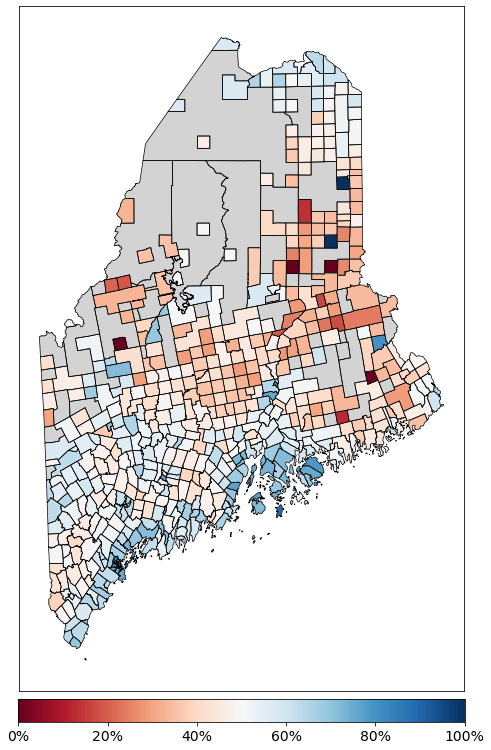

In [16]:
# Plot the outline of the districts (this cleans up issues where adjacent districts have thicker outlines)
plt = join_20.boundary.plot(color = "black", linewidth = .7, figsize = (8, 15))
join_20.plot(ax = plt, color = "lightgrey", linewidth = .7)

# Plot a choropleth map of the districts by dem vote %
join_20.plot(ax = plt, column = 'dem_pct', cmap ="RdBu", legend = True, legend_kwds={'orientation': "horizontal", "pad": 0.01}, linewidth = .3, edgecolor = "#FFFFFF", vmin=0, vmax = 100)

# Make the x and y axes markings not show up
plt.xaxis.set_visible(False)
plt.yaxis.set_visible(False)

# Get the choropleth object to update the title
fig = plt.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))


# Change the labels from showing negative percentages
# labels_og = [item.get_text() for item in cb_ax.get_xticklabels()]
# locs_og = [item for item in cb_ax.get_xticks()]
# labels = ['100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%']
# cb_ax.set_xticks(locs_og)
# cb_ax.set_xticklabels(labels)

# Save the figure
plt.figure.savefig("./example_map_2020.png",bbox_inches="tight", dpi = 227)

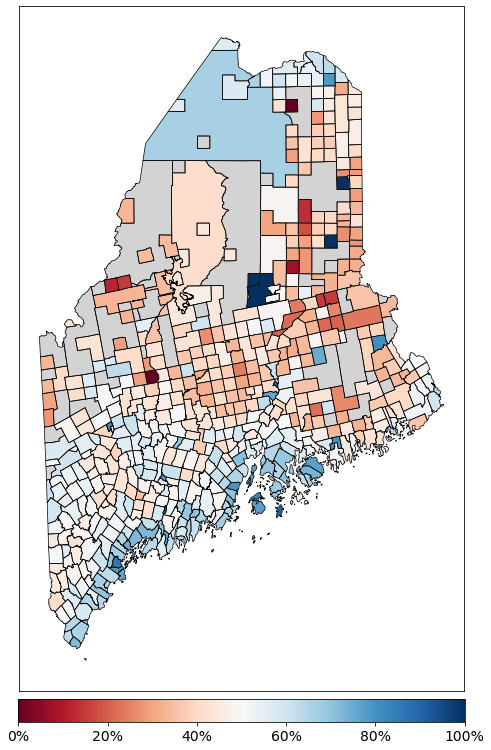

In [17]:
# Plot the outline of the districts (this cleans up issues where adjacent districts have thicker outlines)
plt = join_18.boundary.plot(color = "black", linewidth = .7, figsize = (8,15))
join_18.plot(ax = plt, color = "lightgrey", linewidth = .7)

# Plot a choropleth map of the districts by dem vote %
join_18.plot(ax = plt, column = 'dem_pct', cmap ="RdBu", legend = True, legend_kwds={'orientation': "horizontal", "pad": 0.01}, linewidth = .3, edgecolor = "#FFFFFF", vmin=0, vmax = 100)

# Make the x and y axes markings not show up
plt.xaxis.set_visible(False)
plt.yaxis.set_visible(False)

# Get the choropleth object to update the title
fig = plt.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))


# Change the labels from showing negative percentages
# labels_og = [item.get_text() for item in cb_ax.get_xticklabels()]
# locs_og = [item for item in cb_ax.get_xticks()]
# labels = ['100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%']
# cb_ax.set_xticks(locs_og)
# cb_ax.set_xticklabels(labels)

# Save the figure
plt.figure.savefig("./example_map_2018.png",bbox_inches="tight", dpi = 227)

## Old Map

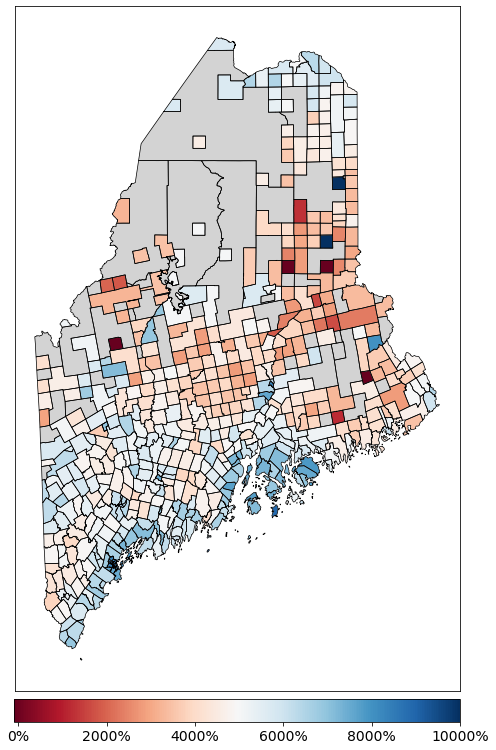

In [18]:
# Plot the outline of the districts (this cleans up issues where adjacent districts have thicker outlines)
plt = join_20.boundary.plot(color = "black", linewidth = .7, figsize = (8, 15))
join_20.plot(ax = plt, color = "lightgrey", linewidth = .7)

# Plot a choropleth map of the districts by registered dem voters
join_20.plot(ax = plt, column = 'net_pct', cmap ="RdBu", legend = True, legend_kwds={'orientation': "horizontal", "pad": 0.01}, linewidth = .3, edgecolor = "#FFFFFF" )

# Set the title
#plt.set_title("Percent Democratic Vote for U.S. Congress \n by ME Town or Ward - 2020", size = 20)

# Add in antotations of the district number using the dict we defined above
#new_cong.apply(lambda x: plt.annotate(text=x["new_cong"], xy=mapping_dict[x["new_cong"]], ha='center', fontsize = 22, color = "white"), axis=1, );

# Make the x and y axes markings not show up
plt.xaxis.set_visible(False)
plt.yaxis.set_visible(False)

# Get the choropleth object to update the title
fig = plt.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))


#cb_ax.set_title("% Vote", fontsize=16, y = -2.5)

# Save the figure
plt.figure.savefig("./example_map_2020.png",bbox_inches="tight", dpi = 227)